In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from binance.client import Client

# Authentication

In [3]:
API_KEY = ''
SECRET_KEY = ''
client = Client(API_KEY, SECRET_KEY) 

# Other Endpoints

There are some other endpoints that may need some consideration. These include, general, wallet, spot and margin trading endpoints. Keep an eye on these but don't get too caught up as there is a little too much. Maybe review these when the trading bot is near completion.

# Market Endpoint

Right now our model works fine with orderbook, ticker and other endpoints. Can keep an eye on these but seems unnecessary.

In [4]:
#get kline data
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Jan, 2017", "31 Dec, 2020")

In [5]:
#put in dataframe
kline_df = pd.DataFrame(klines)
#rename columns
kline_df.columns = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']

#Use .shift to predict 1 hour ahead
kline_df['Future Open'] = kline_df['Open']
kline_df['Future High'] = kline_df['High']
kline_df['Future Low'] = kline_df['Low']
kline_df['Future Close'] = kline_df['Close']

kline_df['Future Open'] = kline_df['Future Open'].shift(-1)
kline_df['Future High'] = kline_df['Future High'].shift(-1)
kline_df['Future Low'] = kline_df['Future Low'].shift(-1)
kline_df['Future Close'] = kline_df['Future Close'].shift(-1)

#drop null value after shifting and drop unnecessary columns
kline_df.dropna(inplace=True)
kline_df.drop(['Ignore','Open time','Close time'], inplace=True, axis=1)

#convert kline data to integer/float datatype
numeric_columns = ['Open','High','Low','Close','Volume','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Future Open','Future High','Future Low','Future Close']
kline_df[numeric_columns] = kline_df[numeric_columns].apply(pd.to_numeric,axis=1)

In [6]:
#Repeat steps from above for kline test data
klines_test = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Jan, 2021", "31 Oct, 2021")
kline_test_df = pd.DataFrame(klines_test)
kline_test_df.columns = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']

kline_test_df['Future Open'] = kline_test_df['Open']
kline_test_df['Future High'] = kline_test_df['High']
kline_test_df['Future Low'] = kline_test_df['Low']
kline_test_df['Future Close'] = kline_test_df['Close']

kline_test_df['Future Open'] = kline_test_df['Future Open'].shift(-1)
kline_test_df['Future High'] = kline_test_df['Future High'].shift(-1)
kline_test_df['Future Low'] = kline_test_df['Future Low'].shift(-1)
kline_test_df['Future Close'] = kline_test_df['Future Close'].shift(-1)

kline_test_df.dropna(inplace=True)
kline_test_df.drop(['Ignore','Open time','Close time'], inplace=True, axis=1)
kline_test_df[numeric_columns] = kline_test_df[numeric_columns].apply(pd.to_numeric,axis=1)

## Train_Test_Split

In [7]:
X_train = kline_df.iloc[0:,0:9]
X_train

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171.0,35.160503,1.509525e+05
1,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102.0,21.448071,9.260828e+04
2,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36.0,4.802861,2.079532e+04
3,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25.0,2.602292,1.129135e+04
4,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28.0,0.814655,3.552747e+03
...,...,...,...,...,...,...,...,...,...
29446,28510.86,28900.05,28444.00,28776.46,7242.879514,2.081010e+08,119364.0,4001.209384,1.149579e+08
29447,28776.45,28996.00,28603.24,28785.67,4271.327517,1.230356e+08,81707.0,2015.483662,5.807157e+07
29448,28785.67,28980.00,28534.70,28875.21,3551.040384,1.022468e+08,77627.0,1729.515881,4.981248e+07
29449,28875.21,28903.93,28571.84,28703.88,1915.683224,5.510670e+07,57210.0,899.666792,2.588750e+07


In [8]:
y_train = kline_df.iloc[:, -1]
y_train

0         4315.32
1         4324.35
2         4349.99
3         4360.69
4         4444.00
           ...   
29446    28785.67
29447    28875.21
29448    28703.88
29449    28875.54
29450    29120.51
Name: Future Close, Length: 29451, dtype: float64

In [9]:
X_test = kline_test_df.iloc[0:,0:9]
X_test

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,28923.63,29031.34,28690.17,28995.13,2311.811445,6.676883e+07,58389.0,1215.359238,3.510354e+07
1,28995.13,29470.00,28960.35,29409.99,5403.068471,1.583578e+08,103896.0,3160.041701,9.261399e+07
2,29410.00,29465.26,29120.03,29194.65,2384.231560,6.984265e+07,57646.0,1203.433506,3.525275e+07
3,29195.25,29367.00,29150.02,29278.40,1461.345077,4.276078e+07,42510.0,775.915666,2.270555e+07
4,29278.41,29395.00,29029.40,29220.31,2038.046803,5.961464e+07,55414.0,1003.342834,2.934638e+07
...,...,...,...,...,...,...,...,...,...
6853,58300.03,58532.54,58075.13,58210.46,2004.084616,1.168147e+08,64158.0,1084.455616,6.321684e+07
6854,58210.46,58260.76,58023.64,58065.99,945.022300,5.493669e+07,31519.0,458.172670,2.663427e+07
6855,58065.99,58169.99,57678.06,57986.55,1726.702190,1.000249e+08,52028.0,867.359610,5.024628e+07
6856,57986.54,58113.38,57800.00,57965.01,1290.498850,7.480301e+07,38821.0,734.903250,4.259771e+07


In [10]:
y_test = kline_test_df.iloc[:, -1]
y_test

0       29409.99
1       29194.65
2       29278.40
3       29220.31
4       29187.01
          ...   
6853    58065.99
6854    57986.55
6855    57965.01
6856    57673.39
6857    57767.97
Name: Future Close, Length: 6858, dtype: float64

## Scale Down Data

In [11]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train)

MinMaxScaler()

In [12]:
X_train_normal = scalar.transform(X_train)
X_test_normal = scalar.transform(X_test)

## Apply Neural Network

In [13]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(256),activation= 'relu', solver= 'adam',learning_rate='adaptive')

nn.fit(X_train_normal, y_train)

D:\Downloads\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=256, learning_rate='adaptive')

In [14]:
y_train_pred = nn.predict(X_train_normal)
print("MSE: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("MAE: ", mean_absolute_error(y_train, y_train_pred))
print("r2-squared: ", r2_score(y_train, y_train_pred))

MSE:  10208.156566771557
RMSE:  101.03542233678027
MAE:  51.228167121651424
r2-squared:  0.9992458910877651


In [15]:
y_test_pred = nn.predict(X_test_normal)
print("MSE: ", mean_squared_error(y_test, y_test_pred))   
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("MAE: ", mean_absolute_error(y_test, y_test_pred))
print("r2-squared: ", r2_score(y_test, y_test_pred))

MSE:  1447536.7616535155
RMSE:  1203.136219076425
MAE:  975.0110940640935
r2-squared:  0.9825248609380677


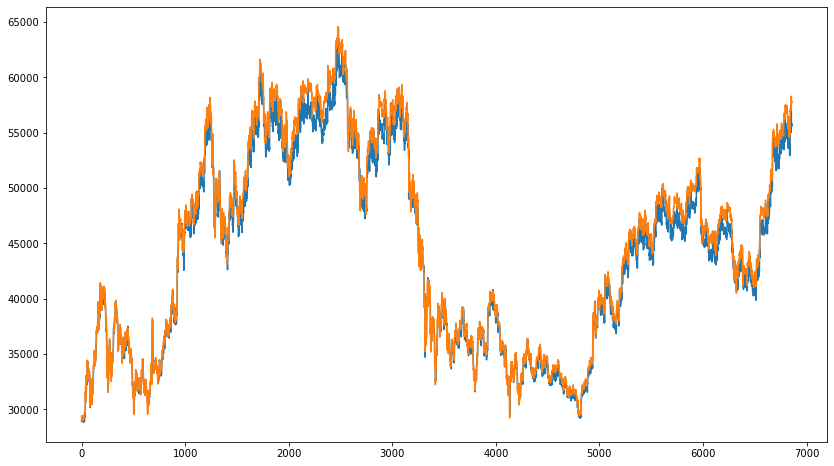

In [16]:
plt.figure(figsize=(14,8))
plt.plot(y_test_pred)
plt.plot(y_test)

Blue line represents predictions and orange line represents actual prices. This graph may make our neural network look accurate but upon close examination, it was found that the model's predictions were lagging behind. If the price of a coin rose by 5 USD in a 30 minute time interval, we would only be able to predict this accurately at the end of that interval.